# COVID-19
#### Fitting a RNN network onto country with similar growth

The aim of this notebook is to provide a solution for predicting the feature spread of the COVID-19 pandemic using Reccurent Neural Networks. Besides this, it is inteded to be educational and to explaing some basic concepts of working and using a RNN in the context of multi-time series prediction.

## Introduction

Training a single model for all countries can raise a multitude of problems one of them being data scaling. Neural networks need data represented in a small interval, usually in the range \[-1, 1\]. The samples that we are working with consist of the number of confirmed cases and fatalities, each of it being grouped by country. These entries have a very high standard deviation and trying to normalize this data by applying a single scale factor over the whole dataset will lead to into a big preccision loss and would not help at all. We address this problem by diving the training for each individual country and only consider its nearest neighbours inn terms of COVID-19 spread growth. 

## Imports

Importing data from external packages.

In [1]:
import warnings 
warnings.filterwarnings('ignore')

In [2]:
import os
import time
import torch
import statistics

import numpy   as np 
import pandas  as pd

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.metrics       import mean_squared_log_error
from sklearn.preprocessing import StandardScaler

from tqdm.notebook    import tqdm
from IPython.display  import display_html 

from torch import nn
from torch import optim
from torch.optim import lr_scheduler

Import local packages

In [3]:
from core.networks  import BasicRecurrentPredictor
from core.nn        import WeightInitializer

from core.data      import compare_countries as cc
from core.data      import utils             as dataUtils

from core.nn.loss   import l1_norm_error, rmsle_error

In [4]:
# sns.set()

# set values for reproduceble results
torch.manual_seed(123);
torch.cuda.manual_seed(123)
np.random.seed(123)

### Globals

In [5]:
COUNTRY      = 'Germany'
WIN_SIZE     = 10
OBS_SIZE     = 5
TRAIN_UP_TO  = pd.to_datetime('2020-04-20')
DEVICE       = 'cpu'

## Data

The initial data which this notebook used is the one from [Kaggle's COVID-19 spread prediciton](https://www.kaggle.com/c/covid19-global-forecasting-week-4) competition. It consists of countries and their states(where needed) and the number of confirmed cases and fatalities per day. Because this source will no longer be updated, the data will be collected from this [GitHub](https://github.com/CSSEGISandData/COVID-19) reposity  created by Johns Hopkins CSSE. Also the sources ```.csv``` have different formats(columns), I have chosen to work with the original format.

Inorder to use this notebook with the latest data, please run the script ```scripts/convert_data_format.py ```. This will download the data direct from the repo and convert it to the appropiate format.

### Loading the data

In [6]:
allData = pd.read_csv('assets/covid_spread.csv', parse_dates=['Date'])
allData.head()

,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,NaN,Afghanistan,2020-01-22,0.0,0.0
1,NaN,Afghanistan,2020-01-23,0.0,0.0
2,NaN,Afghanistan,2020-01-24,0.0,0.0
3,NaN,Afghanistan,2020-01-25,0.0,0.0
4,NaN,Afghanistan,2020-01-26,0.0,0.0


For make the data easier to use, I will work "Province_State" based. The preprocessing step will replace the Province_state with the name of the country (if it has no state).

In [7]:
allData = dataUtils.preprocess_data(allData)
allData.head()

,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,Afghanistan,Afghanistan,2020-01-22,0.0,0.0
1,Afghanistan,Afghanistan,2020-01-23,0.0,0.0
2,Afghanistan,Afghanistan,2020-01-24,0.0,0.0
3,Afghanistan,Afghanistan,2020-01-25,0.0,0.0
4,Afghanistan,Afghanistan,2020-01-26,0.0,0.0


### Computing the errors

In the previous notebook I have explained how getting the nearest neighbour work. But as a short revision, only take the countries which are more "advanced" in the pandemic that the source country, select the data using a threshold(for confirmed and fatalities discard everything that is smaller than this) and to search for the smallest error by slidding the source over the target and computing it at every step. The final error is represented by the smalles error, also it is stored the index from which that happened.  

The result is a dataframe containing the following:
- **Province_State** : the name of the state/province
- **deathError**     : the minimum error that was found between source and that specific country for fatalities
- **deathIdx**       : the index where the above error was found (in the thresholded array)
- **confirmedError** : the minimum error that was found between source and that specific country for confirmed cases
- **confirmedIdx**   : the index where the above error was found (in the thresholded array)

When comparing, I choose to use L1 normalized with the source value. This will give us the error in percentage, this is a  easier to interpret and understand.  


In [8]:
errorData  = cc.get_nearest_sequence(allData, COUNTRY, 
                                     alignThreshConf = 500,
                                     alignThreshDead = 20,  
                                     errorFunc       = l1_norm_error
                                    )

errorData.sort_values(by='confirmedError').head()

,Province_State,deathError,confirmedError,deathIdx,confirmedIdx
3,Italy,1.045771,0.116875,0,0
1,Hubei,0.322441,0.433184,0,0
2,Iran,0.269927,0.511838,3,0
4,"Korea, South",0.818740,0.707273,3,0
0,Henan,0.907373,0.865374,16,2


### Creating traning data

We select the for training only the countries that have an average error smaller that a threshold. I do this for both confirmed cases and fatalities and this is due to the fact that there are goinf to be trained one RNN model for each attribute. This will be further splitted andtransformed into bacthes splitted into test and validation data.

In [9]:
confData = dataUtils.get_target_data(allData, errorData, 
                                     errorThresh = 0.6, 
                                     country     = COUNTRY, 
                                     target      = 'confirmed')
deadData = dataUtils.get_target_data(allData, errorData, 
                                     errorThresh = 1.5, 
                                     country     = COUNTRY, 
                                     target      = 'fatalities')

confData.head()

,Date,Province_State,ConfirmedCases
14611,2020-01-31,Italy,2.0
14612,2020-02-01,Italy,2.0
14613,2020-02-02,Italy,2.0
14614,2020-02-03,Italy,2.0
14615,2020-02-04,Italy,2.0


One important aspect is scaling the date. I will use the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) because a small standard deviation is expected for features. This scaler will be further used for scaling both the training data and the model predictions.

In [10]:
confScaler = dataUtils.get_scaler(confData, 'confirmed')
deadScaler = dataUtils.get_scaler(deadData, 'fatalities')

## Predicting

### Model

The reccurent predictor is composed from 2 parts:
- reccurent cells  
- multi layer perceptron that is applied after each encoded timpestamp 
Each part will be individually configured. For a detailed view, you can consult [networks](core/networks) package.

We are going to train 2 individual models for each feature, Confirmed Cases and Fatalities. The reason for this _split_ is the fact the data is not of equal length and this would be a little bit of an overhead for solving in this notebook. 

In the following section, I will explain and motivate the configuration and personal choices that I have made: 

![RNN_Flow](assets/images/rnn_model.png)

#### Parameters

These define overall shapes of the data and the size of the embeddings:
- **chNo**   : the number of input and output features, they must have the same length, in out case this       
- **future** : the number of timestapms to predict into the feature 

#### RNN parameters

- **rnnCell** : are the RNN cell types that are supported in Pytorch (LSTM/GRU/RNN), the most powerfull one is LSTM and also the choice that we are going to treat, but when having little data(like in our case) GRU may generalize better in some cases, RNNCell is also an option yet, and it yielded the worst results
- **rnnNoCells** : represent the number of reccurent cells in the model
    a higher number leads to a very unstable model (especially for this task) and the exploding gradients problem occurs very often during training 
- **hidChNo** : number of RNN cell hidden dimension

**Note**: yes, this part could have been implement using the higher level and more optimized [API](https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM) from PyTorch, but I think this is more expressive and easier to understand and it is not such does not require a lot more code

#### MLP parameters

- **mlpLayerCfg** : a list with the numbers of neurons in each hidden layer, from observation, the layer might be wide but is to be avoided having a very deep network (numerical instability during training and no real benefit from it)
- **mlpActiv** : activation layer after each dense/linear layer, I have used [PReLU](https://pytorch.org/docs/stable/nn.html#prelu) which is a sort of learnable loss and has a good representation for the negative interval and does not bound the values between a range 
- **dropRate** : dropout rate applied after each dense/linear layer, for our case none is used
- **normType** : normalization layer, none is used
- **mlpActivLast** : the activation of the last 

## Training

Because the both Confirmed and Fatalities are going to follow the same lead and only a few parameters will vary, I will only explain once everything and add a few notes if that will be necessarly. 

In [11]:
w = WeightInitializer()

Moving on, the model will have the weights initialized as as follows:
- RNN : default (provided by PyTorch)
- MLP : normal distribution

### Confirmed

For this section we have more data, since the cases have started earlier and the fatalities came later on. 

Let's initialize the model:

In [12]:
# build the model
confModel = BasicRecurrentPredictor(
            # parameters
            chNo        = 1,          # number of input features
            future      = 0,
            returnFullSeq = True,     # return both the encoded sequence 
                                      # and the future prediction
    
            # RNN
            rnnCell     = 'LSTMCell', # RNN cell type (LSTM/GRU/RNN)
            rnnNoCells  = 1,          # no of RNN cells
            hidChNo     = 16,         # number of RNN cell hidden dimension
            
            # MLP
            mlpLayerCfg   = [4],      # layer hidden dims
            mlpActiv      = 'PReLU',  # inner activation of the mlp
            dropRate      = None,     # dropout rate for each layer of mlp
            normType      = None,     # normalization type
            mlpActivLast  = None      # note that every timestamp 
                                      # in the sequence will be activated too
            
            ).build()

And init the weights as previously mentioned.

In [13]:
w.init_weights(confModel, 'normal_', {})

Split the dataframe from the previously selected data into batches and normalize it. The data is only select until a specific date, and the rest is left for validation.  

In [14]:
confTrainData = dataUtils.get_train_data(confData, 'confirmed', 
                                  step       = 1,
                                  winSize    = WIN_SIZE, 
                                  trainLimit = TRAIN_UP_TO, 
                                  scaler     = confScaler,
                                  shuffle    = True)
confTrainData.shape

torch.Size([278, 10, 1])

As training loss we use [SmoothL1Loss](https://pytorch.org/docs/stable/nn.html#torch.nn.SmoothL1Loss)(Huber Loss), it is less sensitive to outliers than MSELoss and prevents exploding gradients.

As optimization algorithm the second order optimization algorithm LBFGS is chosed, it is a very memory expensive algorithm, but since we have such little data, it can be easily used. For more details about how it works I leasve the following link on [Quora](https://www.quora.com/Is-the-L-bfgs-always-better-than-stochastic-gradient-descent?share=1).

In [15]:
confLoss  = nn.SmoothL1Loss()
confOptim = optim.LBFGS(confModel.parameters(), 
                        lr             = 0.05, 
                        max_iter       = 75, 
                        tolerance_grad = 1e-7, 
                        history_size   = 75)

Now let's move everything onto the same device.

In [16]:
confModel.to(DEVICE);
confTrainData = confTrainData.to(DEVICE);

The closure is the function that is passed to the optimizers. Here is the "bussines logic" of the training process. For the first OBS_SIZE steps, the models prediction is based on the input data, from there, it usus it's own prediction. The whole sequence is returned and evaluted for optimization. 

For better stability, after the loss is computed, the gradients are clipped such that their L2 norm is 1. For more details check this article on [MachineLearningMastery](https://machinelearningmastery.com/exploding-gradients-in-neural-networks/).

In [17]:
def conf_closure():
    confOptim.zero_grad()
    confModel.returnFullSeq = True
    
    # slice data
    future  = WIN_SIZE - OBS_SIZE
    obsData = confTrainData[:,:OBS_SIZE]
    
    # make prediction
    out  = confModel(obsData, future = future).reshape(-1, WIN_SIZE, 1)
    
    # compute gradients
    loss = confLoss(out, confTrainData)
    loss.backward()
    
    # clip gradients / numerical stability
    nn.utils.clip_grad_norm_(confModel.parameters(), 1.0)
      
    return loss

conf_closure()

tensor(0.2991, grad_fn=<SmoothL1LossBackward>)

Training loop

In [18]:
pBar = tqdm(range(14))
for i in pBar:
    loss = confOptim.step(conf_closure)
    pBar.set_postfix({'Loss ' : loss.item(), 
                      'Lr'    : confOptim.param_groups[0]['lr']})
    
    if torch.isnan(loss):
        raise ValueError('Loss is NaN')

#### Evaluate training

The validation data includes the last OBS_SIZE from training data. This is going to be fed into the model to predict the future cases.

In [19]:
confValData, confValLabel = dataUtils.get_val_data(confData, 'confirmed', 
                                                   COUNTRY, 
                                                   TRAIN_UP_TO, 
                                                   OBS_SIZE, 
                                                   confScaler)
confValData = confValData.to(DEVICE)

For evaluating the prediction, RMLSE is used. This is the metric also chosed by Kaggle to evaluate the submissions on Spread forecast. The error is only computed on the predicted future and not on the predicted observation period. 

RMSLE : 0.03664  (not normalized)


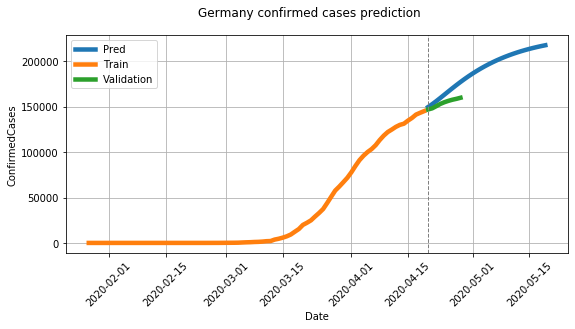

In [20]:
confModel.eval()
# get figure
fig, ax = plt.subplots(1, 1, figsize = (9, 4))
ax.tick_params(axis='x', rotation=45)
fig.suptitle(COUNTRY + ' confirmed cases prediction')

# make prediction
confModel.returnFullSeq = False
pred   = confModel(confValData, future = 30).cpu().detach().numpy()
pred   = confScaler.inverse_transform(pred[0])

error  = rmsle_error(pred[:confValLabel.shape[0]], confValLabel)
print("RMSLE : %2.5f"% error.item(), ' (not normalized)')             

# prediction
predDate = pd.date_range(start = TRAIN_UP_TO, periods=pred.shape[0])              
sns.lineplot(y = pred, x = predDate, ax = ax, linewidth=4.5)

# plot train data
showTrainData = confData[confData['Province_State'] == COUNTRY]
showTrainData = showTrainData[showTrainData['Date'] < TRAIN_UP_TO]
sns.lineplot(y = 'ConfirmedCases', x = 'Date', data = showTrainData, ax = ax, linewidth=4.5)

# plot val data
showValData = confData[confData['Province_State'] == COUNTRY]
showValData = showValData[showValData['Date'] >= TRAIN_UP_TO]
sns.lineplot(y = 'ConfirmedCases', x ='Date', data = showValData, ax = ax, linewidth=4.5);

ax.legend(['Pred', 'Train', 'Validation'])
ax.axvline(x=TRAIN_UP_TO, ymin = 0.0, ymax = 1.0, linestyle='--', lw = 1, color = '#808080')
ax.grid(True)

### Fatalities

Initialize the model

In [21]:
# build the model
deadModel = BasicRecurrentPredictor(
            # basic parameters
            chNo        = 1,                # number of input features
            future      = 0,
            returnFullSeq = True,
    
            # RNN
            rnnCell     = 'LSTMCell',       # RNN cell type (LSTM/GRU/RNN)
            rnnNoCells  = 1,                # no of RNN cells
            hidChNo     = 16,               # number of RNN cell hidden dimension
    
            # MLP
            mlpLayerCfg   = [4],            # layer hidden dims
            mlpActiv      = 'PReLU',        # inner activation of the mlp
            dropRate      = None,           # dropout rate for each layer of mlp
            normType      = None,           # normalization type
            mlpActivLast  = None,           # note that every timestamp in the sequence 
                                            # will be activated too
            ).build()

Initialize models weights.

In [22]:
w.init_weights(deadModel, 'normal_', {})

Get training data

In [23]:
deadTrainData = dataUtils.get_train_data(deadData, 'fatalities', 
                                      step       = 1,
                                      winSize    = WIN_SIZE, 
                                      trainLimit = TRAIN_UP_TO, 
                                      scaler     = deadScaler,
                                      shuffle    = True)
deadTrainData.shape

torch.Size([342, 10, 1])

Loss and optimizer

In [24]:
deadLoss  = nn.SmoothL1Loss()
deadOptim = optim.LBFGS(deadModel.parameters(), 
                        lr             = 0.065, 
                        max_iter       = 80, 
                        tolerance_grad = 1e-7, 
                        history_size   = 75)

In [25]:
deadModel.to(DEVICE);
deadTrainData = deadTrainData.to(DEVICE);

In [26]:
def dead_closure():
    deadOptim.zero_grad()
    
    # slice data
    predSize = WIN_SIZE - OBS_SIZE
    obsData  = deadTrainData[:,:OBS_SIZE]

    out  = deadModel(obsData, future = predSize).reshape(-1, WIN_SIZE, 1)
 
    # compute and backprop loss
    loss = deadLoss(out[:, :WIN_SIZE], deadTrainData)   
    loss.backward()
    
    # clip gradient for numerical stability
    nn.utils.clip_grad_norm_(deadModel.parameters(), 1.0)
    
    return loss
dead_closure()

tensor(0.3438, grad_fn=<SmoothL1LossBackward>)

Training loop

In [27]:
pBar = tqdm(range(10))
for i in pBar:
    loss = deadOptim.step(dead_closure)
    pBar.set_postfix({'Loss ' : loss.item()})
    
    if torch.isnan(loss):
        raise ValueError('Loss is NaN')

#### Evaluate training

In [28]:
deadValData, deadValLabel = dataUtils.get_val_data(deadData, 'fatalities', 
                                                   COUNTRY, 
                                                   TRAIN_UP_TO, 
                                                   OBS_SIZE, 
                                                   deadScaler)
deadValData = deadValData.to(DEVICE)

tensor(0.0803)


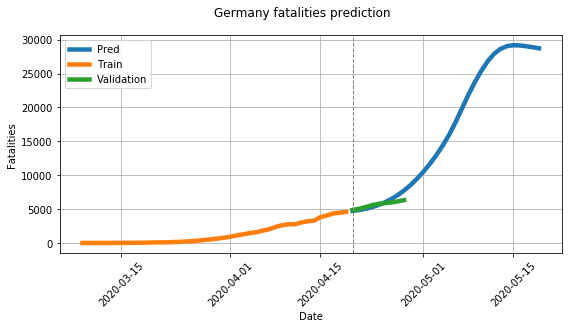

In [31]:
deadModel.eval()

# get figure
fig, ax = plt.subplots(1, 1, figsize = (9, 4))
ax.tick_params(axis='x', rotation=45)
fig.suptitle(COUNTRY + ' fatalities prediction')

# make prediction
deadModel.returnFullSeq = False
pred   = deadModel(deadValData, future = 30).cpu().detach().numpy()
pred   = deadScaler.inverse_transform(pred[0])
error  = rmsle_error(pred[:deadValLabel.shape[0]], deadValLabel)
print(error)             

# plot prediction
predDate = pd.date_range(start = TRAIN_UP_TO, periods=pred.shape[0])              
sns.lineplot(y = pred, x = predDate, ax = ax, linewidth=4.5 )

# plot train data
showTrainData = deadData[deadData['Province_State'] == COUNTRY]
showTrainData = showTrainData[showTrainData['Date'] < TRAIN_UP_TO]
sns.lineplot(y = 'Fatalities', x = 'Date', data = showTrainData, ax = ax, linewidth=4.5)

# plot val data
showValData = deadData[deadData['Province_State'] == COUNTRY]
showValData = showValData[showValData['Date'] >= TRAIN_UP_TO]
sns.lineplot(y = 'Fatalities', x ='Date', data = showValData, ax = ax, linewidth=4.5);

ax.legend(['Pred', 'Train', 'Validation'])
ax.axvline(x=TRAIN_UP_TO, ymin = 0.0, ymax = 1.0, linestyle='--', lw = 1, color = '#808080')
ax.grid(True)